In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

In [2]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [15]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in range(115, 1160, 116)], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:]

aux.shape, targets.shape, run_path

((1160, 5),
 (1160, 22),
 '/media/beans/ssd/blender_membank/dataloader_01/run_20')

In [16]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

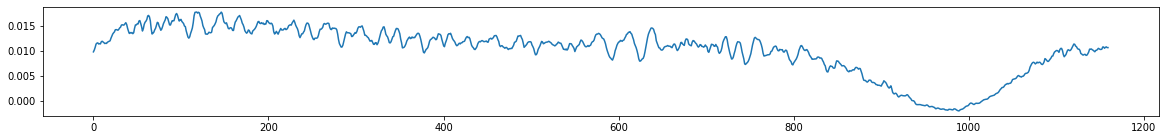

In [17]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

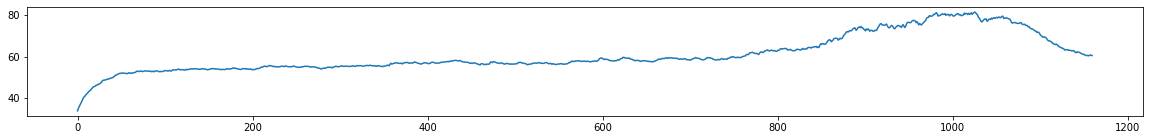

In [18]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

<BarContainer object of 10 artists>

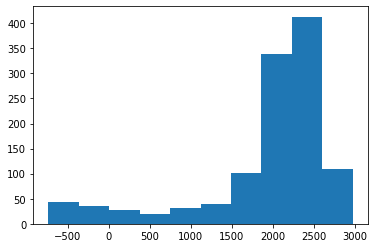

In [19]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

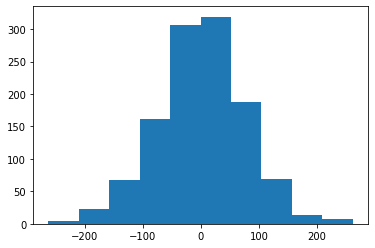

In [20]:
plt.hist(torque[1:]-torque[:-1])[2]

In [21]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [22]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    video.write(img)
    
video.release()

In [11]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([10.080934,  9.488617, 17.750319,  0.65616 , 10.859515, 11.407385,
       10.6909  , 10.125799, 12.384958, 10.82023 ,  8.79699 , 14.3366  ],
      dtype=float32)

In [205]:
all_aux = []
all_targets = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        all_aux.append(aux)
        all_targets.append(targets)
        
all_aux = np.stack(all_aux, axis=0)
all_targets = np.stack(all_targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [194]:
all_aux.shape

(347, 1160, 5)

In [195]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_targets[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

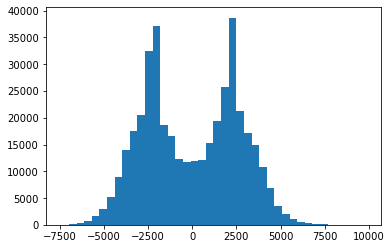

In [196]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

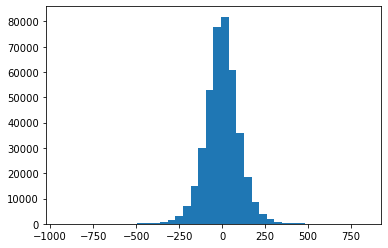

In [197]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [198]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(464.77068937763715, 6650.889820211277)

In [199]:
all_targets.shape

(347, 1160, 22)

In [200]:
mean_angles = abs(all_targets).mean(axis=0).mean(0)
mean_angles

array([0.01825937, 0.02071294, 0.02322304, 0.02576743, 0.0283329 ,
       0.03091071, 0.033494  , 0.0360781 , 0.03866021, 0.0412382 ,
       0.04381006, 0.04637459, 0.04893045, 0.05147666, 0.05401279,
       0.05653785, 0.05905137, 0.06155273, 0.06404142, 0.06651726,
       0.0689797 , 0.07142906], dtype=float32)

In [201]:
mean_angles[-1] / mean_angles[0]

3.9119136

<BarContainer object of 40 artists>

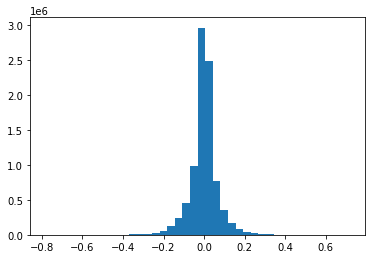

In [202]:
plt.hist(all_targets.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

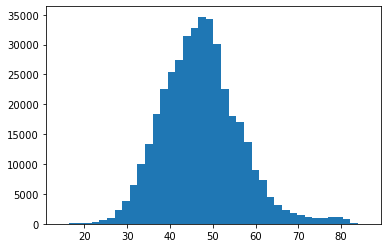

In [203]:
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

In [204]:
all_targets.min()

-0.78187835

In [ ]:
from scipy.signal import convolve2d
def smooth_targets(targets, window_size=4):
    # expects 3 dims, last is just padded
    smoothed = convolve2d(targets[:, :, 0], np.ones((1, window_size)), 'same') / window_size
    smoothed = np.expand_dims(smoothed, -1)
    return smoothed